# Deep Neural Networks

## Overview

you will implement two types of deep learning network (fully connected and convolutional neural networks) to classify images of hands in poses corresponding to letters in American Sign Language. The dataset is contained in the zip file, along with some images and a text file describing the dataset. It is similar to other MNIST datasets.

The main aims of the assignment are:

 - To implement and train two different types of deep learning network;
 
 - To systematically optimise the architecture and parameters of the networks;
  
 - To explore different cases of over-fitting and under-fitting, and know what appropriate actions to take in these cases.
 

This assignment relates to the following ACS CBOK areas: abstraction, design, hardware and software, data and information, HCI and programming.

## General Instructions 

your submission should be formatted as a Jupyter notebook IDE that interleaves Python code with output, commentary and analysis, as indicated in this template.
 - Your code must use the current stable versions of python libraries, not outdated versions.
 - All data processing must be done within the notebook after loading the data.
 - **Before submitting your notebook, make sure to run all cells in your final notebook so that it works correctly.**

This assignment is divided into several tasks. Stick to this notebook format, although feel free to add cells throughout, but keep the same numbering for all instructions, questions and answers.

Make sure to answer every question with *separate answer text (“Answer: ...”) in a cell* and check that you answered all sub-questions/aspects within the question. The text answers are worth points.

Make the *figures self-explanatory and unambiguous*. Always include axis labels, if available with units, unique colours and markers for each curve/type of data, a legend and a title. Give every figure a number (e.g. at start of title), so that it can be referred to from different parts of the text/notebook. This is also worth points!

## Outline

The main steps in the assignment are outlined here, so that you can appreciate the bigger picture. Some of the steps are purely for testing your knowledge and demonstrating certain things, but in general it outlines the main process that you would go through to solve a practical problem.

- To start with we load the data, visualise and explore it. You should always do this in any problem.

- After this we will establish how long a simple network takes to run on a given amount of training data on your computer. This is important for this assignment as you have to run on your own machines, and we need to make sure it runs in a reasonable amount of time. In a practical problem you are likely to have a lot more data and will use bigger networks, but it is common that you will have a limit on the available resources and time, so establishing a baseline timing and deciding on constraints is a very common task in any problem.

- Following this we will go through a few specific cases, looking at some extremes and learning to identify common problems, how to spot them and options for how to correct for them.

- Afterwards, the main bulk of the assignment will focus on tuning the networks to give the best performance. This is something you will need to do systematically, and demonstrates the approach that you would take in any practical problem. Some limitations will be given, in order to help you in this assignment, but it should be clear how to extrapolate these to a more general setting for other datasets and tasks.

- Once the optimal network is found, the performance will be evaluated.

- A free choice element at the end will allow you to explore one extra aspect, beyond the limitations imposed above.


## Initialise environment

In [0]:
# Load libraries, etc.
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Add other libraries here
import numpy as np
import pandas as pd
import seaborn as sns
import time 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier


---

## 1. Explore the Dataset

### 1.1 Load the data
 - We will use an MNIST-style dataset of sign language signals (hands), which are all small images (28x28)
 - Files are sign_mnist_train.csv and sign_mnist_test.csv
 - Split up labels and images
 - Reshape images appropriately

In [106]:
# load data
train_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


In [0]:
# split up labels and images
train_label=train_df['label']
test_label=test_df['label']

train_X = train_df.drop(['label'],axis=1)
test_X = test_df.drop(['label'],axis=1)

In [108]:
# reshape images appropriately
X_train = train_X.values.reshape(-1,28,28,1)
print(X_train.shape)

X_test = test_X.values.reshape(-1,28,28,1)
print(X_test.shape)

(27455, 28, 28, 1)
(7172, 28, 28, 1)


### 1.2 Look at the data
- Print out some descriptive information about the dataset
- Show one example image of each class

In [55]:
# print out some descriptive information about the dataset
print(train_df.info())
print(train_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB
None
              label        pixel1  ...      pixel783      pixel784
count  27455.000000  27455.000000  ...  27455.000000  27455.000000
mean      12.318813    145.419377  ...    161.137898    159.824731
std        7.287552     41.358555  ...     63.610415     64.396846
min        0.000000      0.000000  ...      0.000000      0.000000
25%        6.000000    121.000000  ...    128.000000    125.500000
50%       13.000000    150.000000  ...    182.000000    182.000000
75%       19.000000    174.000000  ...    204.000000    204.000000
max       24.000000    255.000000  ...    255.000000    255.000000

[8 rows x 785 columns]


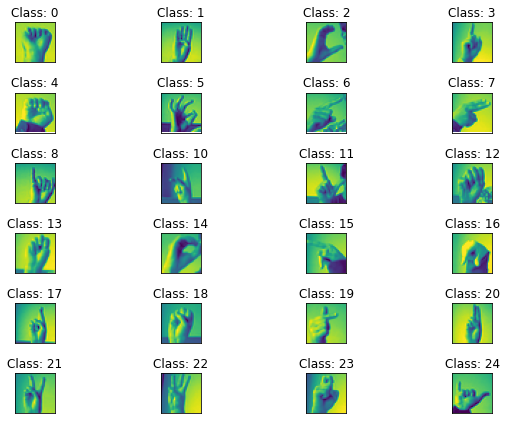

In [83]:
# show one example image of each class
# create list of unique labels and sort it
uniq_label = sorted(train_label.unique())
# create subplots
fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})
# loop through each label
for ax, lbl in zip(axs.flat, uniq_label):
    # filter dataset by label and print first image with this label
    ax.imshow(train_df[train_df.label == lbl].iloc[0, 1:].values.reshape(28,28))
    # set title
    ax.set_title('Class: ' + str(lbl))
# tight_layout automatically adjusts subplot params so that the subplot(s) fits in to the figure area
plt.tight_layout()

### Question 1.3
- Which pair of classes do you think will be the most difficult to distinguish?  Give a reason for your answer.

Answer: Well, its hard to say it for sure beforehand. But I guess it would be hard to distinguish letters u and v (20, 21). Images of u and v letters are very similar.



### 1.4 Look at the labels
- Look at the distribution of the labels
- Adjust for anything that could cause problems later on

Text(0.5, 1.0, 'Distribution of classes in training set')

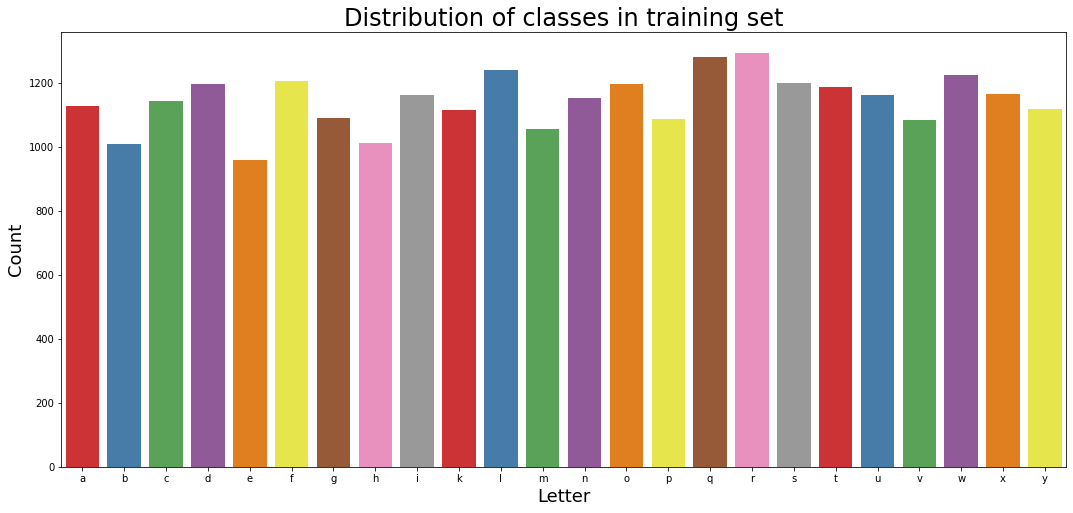

In [57]:
label_tr = train_label.values
# set figsize
plt.figure(figsize = (18,8))
# create seaborn countplot
g=sns.countplot(x =label_tr, palette="Set1")
# set xtick labels
g.set(xticklabels=['a', 'b', 'c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y'])
plt.xlabel('Letter',fontsize=18)
plt.ylabel('Count',fontsize=18)
plt.title('Distribution of classes in training set', fontsize=24)

Text(0.5, 1.0, 'Distribution of classes in test set')

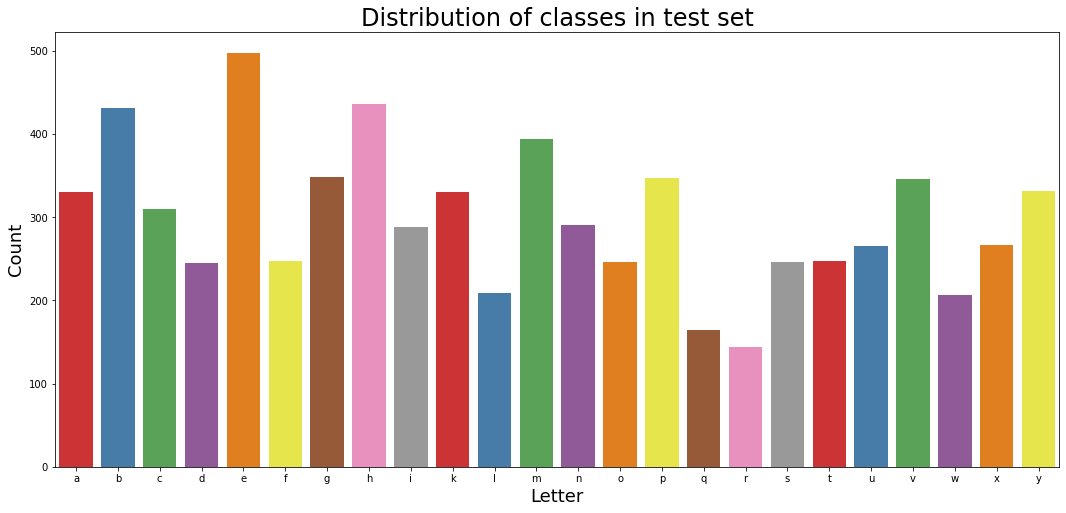

In [58]:
label_tst = test_label.values
plt.figure(figsize = (18,8))
g=sns.countplot(x =label_tst, palette="Set1")
g.set(xticklabels=['a', 'b', 'c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y'])
plt.xlabel('Letter',fontsize=18)
plt.ylabel('Count',fontsize=18)
plt.title('Distribution of classes in test set', fontsize=24)

### 1.5 Split the data (test, validation and training) and scale it
- We will only take the first 2500 training images (which is still over 100 per class) in order to keep run-times down and to make training more challenging. In a practical situation you might either have less data than you'd like or limitations on how much can be processed, so this also reflects a common real-life constraint.
- In this case we will create both the validation and test sets from the testing dataset.  It is unusual to do this, but in this case the training set contains a lot of non-independent, augmented images and it is important that the validation images must be independent. 
- Take 1000 images each for the validation and test sets.
- Scale the data appropriately (e.g. as done for other MNIST datasets).

In [111]:
# create train set
X_trn = X_train[:2500]
X_trn = X_trn / 255
y_trn = train_label.values[:2500]
# create validation set
X_val = X_test[:1000]
X_val = X_val / 255
y_val = test_label.values[:1000]
# create test set
X_tst = X_test[1000:2000]
X_tst = X_tst / 255
y_tst = test_label.values[1000:2000]

print(X_trn.shape, X_val.shape, X_tst.shape)
print(y_trn.shape, y_val.shape, y_tst.shape)

(2500, 28, 28, 1) (1000, 28, 28, 1) (1000, 28, 28, 1)
(2500,) (1000,) (1000,)


### 1.6 Look at label distribution
- Check the label distribution in all three sets and if there are problems, change the selection above.

Text(0.5, 1.0, 'Distribution of classes in training set')

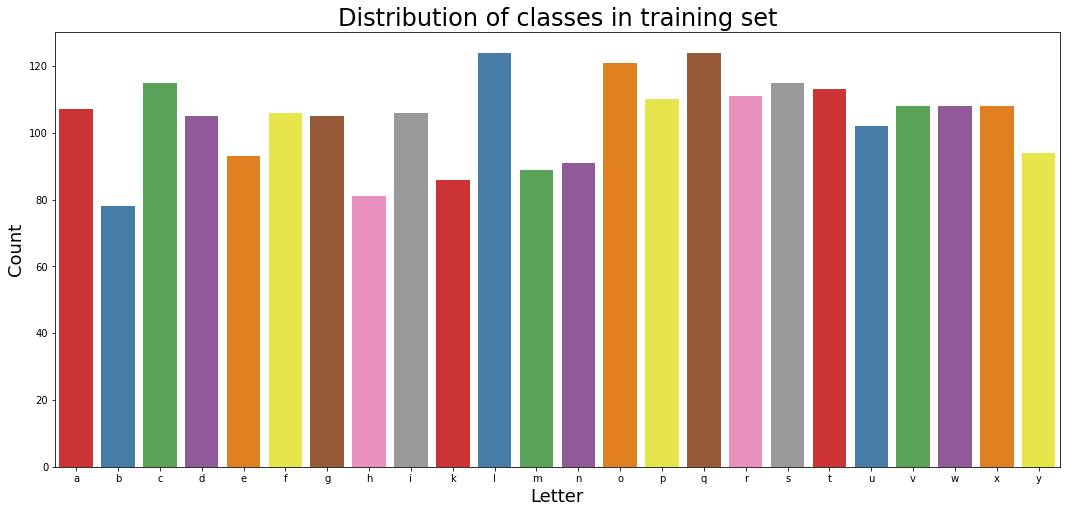

In [78]:
# train labels
plt.figure(figsize = (18,8))
g=sns.countplot(x =y_trn, palette="Set1")
g.set(xticklabels=['a', 'b', 'c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y'])
plt.xlabel('Letter',fontsize=18)
plt.ylabel('Count',fontsize=18)
plt.title('Distribution of classes in training set', fontsize=24)

Text(0.5, 1.0, 'Distribution of classes in validation set')

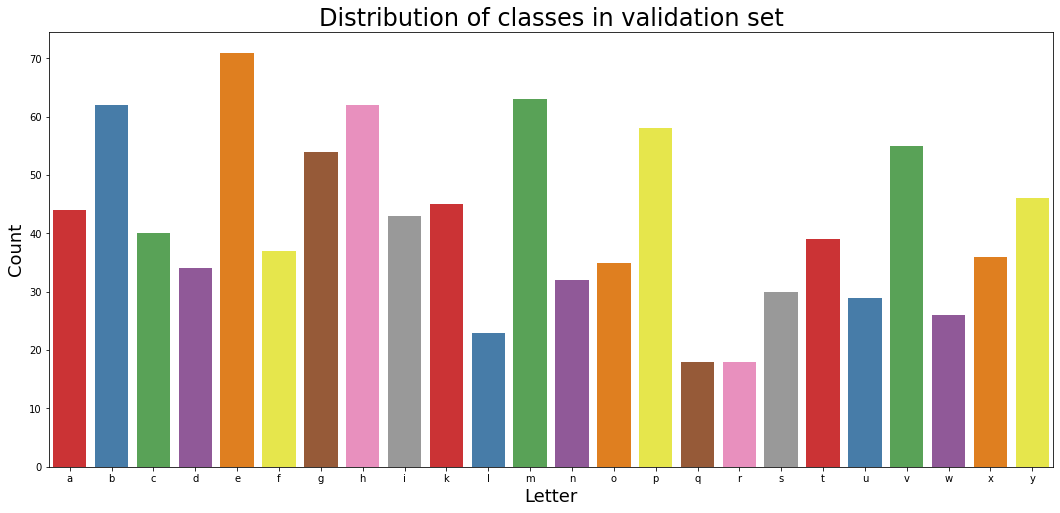

In [79]:
# validation labels
plt.figure(figsize = (18,8))
g=sns.countplot(x =y_val, palette="Set1")
g.set(xticklabels=['a', 'b', 'c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y'])
plt.xlabel('Letter',fontsize=18)
plt.ylabel('Count',fontsize=18)
plt.title('Distribution of classes in validation set', fontsize=24)

Text(0.5, 1.0, 'Distribution of classes in test set')

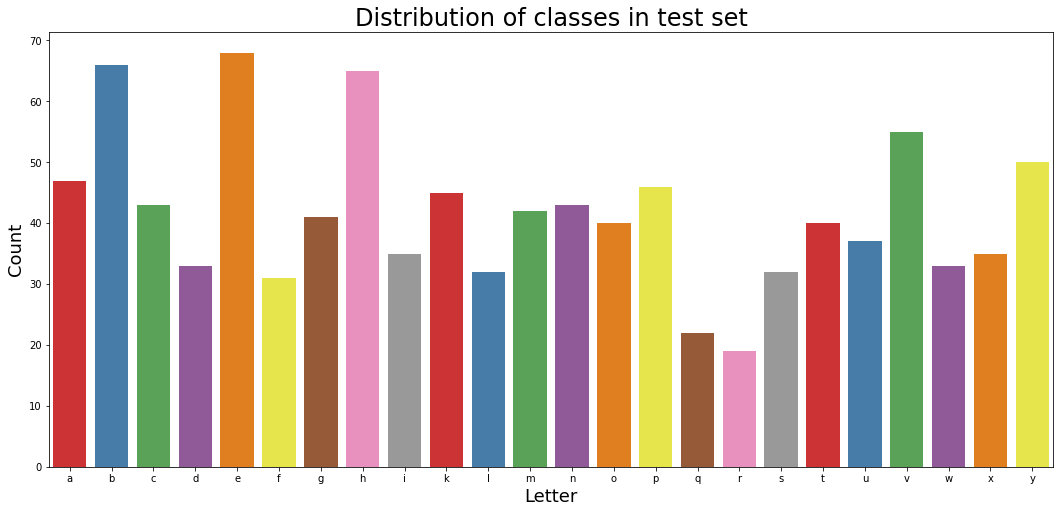

In [80]:
# test labels
plt.figure(figsize = (18,8))
g=sns.countplot(x =y_tst, palette="Set1")
g.set(xticklabels=['a', 'b', 'c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y'])
plt.xlabel('Letter',fontsize=18)
plt.ylabel('Count',fontsize=18)
plt.title('Distribution of classes in test set', fontsize=24)

***

## 2. Initial Deep Learning Networks

In this section you will look at a variety of networks with this data and explore various settings and outcomes.

### Question 2.1
 - We will treat this as a classification problem but we could formulate it as a regression problem instead (predicting the label values as the outcomes). Name one disadvantage that a regression approach would have.



Answer: If the class labels in the classification problem do not have a natural ordinal relationship, the conversion from classification to regression may result in surprising or poor performance as the model may learn a false or non-existent mapping from inputs to the continuous output range.


### Question 2.2
 - What is chance level accuracy (e.g. if predictions were completely random) in this case?


Answer: Accuracy of a random classifier is 1/k(classes are balanced). Here, k is the number of classes in the data set (k=24). So, the accuracy will be 4% for the above scenario.

### 2.3 Timing Test
 - We will start to work out how long it takes to train a moderately sized network on your machine
 - Build a convolutional neural network (CNN) with the following specifications:
   - All filter (kernel) sizes are 3x3
   - Initial Conv2D layer with 64 filters
   - MaxPooling layer following this
   - Second Conv2D layer with 128 filters
   - Dense output layer after this
 - Set the number of epochs to **20** this time (we will use early stopping methods later but **not** now)
 - Set the batch size to 50
 - Use the *Adam* optimiser, with its default learning rate (we will use the Adam optimiser throughout this assignment)
 - Use the *ELU* activation function for the hidden layers (this will be used throughout)
 - Training/Validation/Testing set sizes are 2500/1000/1000, as described above
 - Use time.time() to determine how long it takes to train your network
 - Plot your learning curves (loss functions and accuracies for training and validation)
 - Calculate the accuracies of the network on both the validation and test datasets
 
If this run takes less than 10 minutes then continue with these settings. If it takes much longer than 10 minutes then reduce the number of training points until it is close to 10 minutes. In the case that you cannot achieve this without reducing the number of training points to less than 250, please contact a course organiser, as you may need to use alternative computational resources.

In [92]:
# create model
model=Sequential()
model.add(Conv2D(64,kernel_size=(3,3),
                 strides=1,padding='same',activation='elu',input_shape=(28,28,1)))
model.add(MaxPool2D())
model.add(Conv2D(128,kernel_size=(3,3),
                strides=1,activation='elu',padding='same'))
model.add(MaxPool2D())         
model.add(Flatten())
model.add(Dense(units=25,activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                156825    
Total params: 231,321
Trainable params: 231,321
Non-trainable params: 0
________________________________________________

In [0]:
# compile model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
# one hot encode labels
y_tr = keras.utils.to_categorical(y_trn, num_classes = 25)
y_vl = keras.utils.to_categorical(y_val, num_classes = 25)
y_ts = keras.utils.to_categorical(y_tst, num_classes = 25)

In [120]:
# train model
start = time.time()
history = model.fit(X_trn,
                      y_tr,
                      epochs = 20,
                      batch_size=50,
                      validation_data=(X_val, y_vl))
print(f'It took {time.time() - start} seconds to train')

Train on 2500 samples, validate on 1000 samples
Epoch 1/20
2500/2500 [==============================] - 8s 3ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.5084 - val_accuracy: 0.8830
Epoch 2/20
2500/2500 [==============================] - 8s 3ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.5108 - val_accuracy: 0.8850
Epoch 3/20
2500/2500 [==============================] - 8s 3ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.5095 - val_accuracy: 0.8860
Epoch 4/20
2500/2500 [==============================] - 9s 3ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.4988 - val_accuracy: 0.8840
Epoch 5/20
2500/2500 [==============================] - 9s 3ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.5274 - val_accuracy: 0.8830
Epoch 6/20
2500/2500 [==============================] - 8s 3ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.5344 - val_accuracy: 0.8870
Epoch 7/20
2500/2500 [==============================] - 8s 3ms/step - loss: 0.0014 - acc

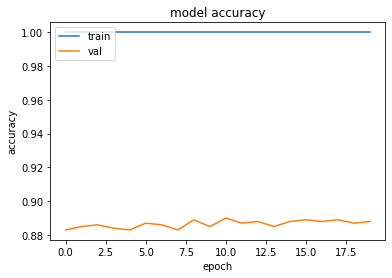

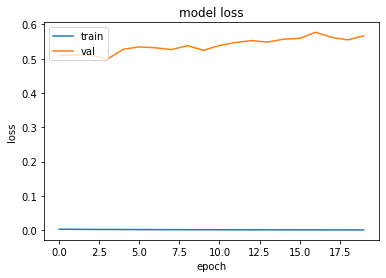

In [135]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Fig1. model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Fig2. model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left');

In [137]:
# evaluate the model
_,acc_val=model.evaluate(X_val, y_vl)
_,acc_test=model.evaluate(X_tst, y_ts)
print(f'Val accuracy: {round(acc_val*100, 2)} %, test accuracy: {round(acc_test*100, 2)}%')

1000/1000 [==============================] - 1s 859us/step
Val accuracy: 88.8 %, test accuracy: 88.6%


### 2.4 Initial Network Exploration
- We will now look at a couple of imperfect cases to get a feeling for what happens in different training situations

### Question 2.5
 - In the following plots, from a network that is being trained, which of the following is demonstrated: (a) under-fitting, (b) over-fitting, (c) unstable/noisy fitting, or (d) not converged? Combinations of these are also possible. Give a reason for your answer.

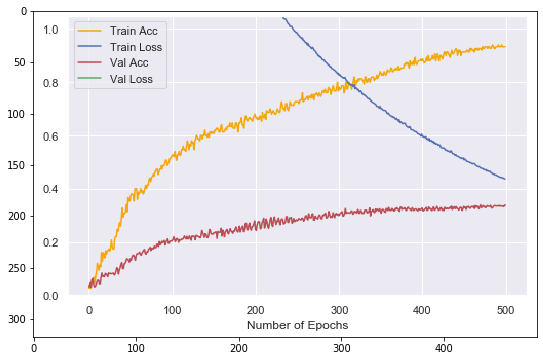

In [0]:
im = plt.imread('LearningPlot1.png')
plt.figure(figsize=(10,6))
plt.imshow(im)
plt.show()

Answer: We can see that train/val accuracies increases and there is a big gap between them. Train loss tends to decrease, but it is still far from 0. We don't see validation loss for unknown reason. Our model is able to predict on data it was trained on really well, but is unable to generalize and accurately predict on data it hasn’t seen before. So, we can conclude that out model overfits the data and it is not converged - we should train more.

### Question 2.6
 - In the following plots, from a network that is being trained, which of the following is demonstrated: (a) under-fitting, (b) over-fitting, (c) unstable/noisy fitting, or (d) not converged? Combinations of these are also possible. Give a reason for your answer.

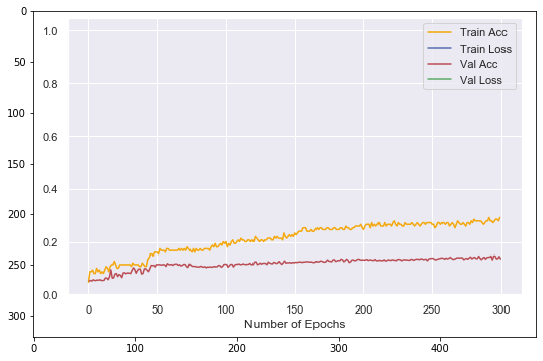

In [0]:
im = plt.imread('LearningPlot2.png')
plt.figure(figsize=(10,6))
plt.imshow(im)
plt.show()

Answer: Given model is not even able to classify the data it was trained on, let alone data it hasn’t seen before. This model underfitting the data.

### Question 2.7
 - Name something that you could do to alleviate problems due to (a) overfitting and (b) underfitting. Provide separate answers for (a) and (b).

Answer:


a) To reduce overfitting:


*   add more data to the training set
*   create additional augmented data by reasonably modifying the data in our training set
*   reduce the complexity of our model
*   regularization

b) To reduce underfitting:


*   increase the complexity of our model
*   add more features to the input samples in our training set
*   reduce regularization 



***

## 3. Main Network Optimisation (50%)

In this section you will undertake the main task of going through the process to find a deep learning solution to this problem that is (within limits) optimised to this specific case.

The following settings for the networks will be fixed:
 - Batch size of 50
 - Maximum number of epochs of 100, but implement *early stopping*
 - Use the *Adam* optimiser
 - Use the *ELU* activation function for all hidden layers (although ReLU is very common, we will explore ELU for this assignment)
 - Use the He Uniform initialization for weights (pass *kernel_initializer="he_uniform"* into the layer specifications)
 - Training/Validation/Testing set sizes are 2500/1000/1000 as described above (with the validation set derived from the original test dataset) unless you needed to reduce the training set size based on your timing tests

You will investigate **both** fully connected and CNN architectures, with the following possibilities:
 - **Number of hidden or Conv2D layers** can be **1, 2 or 3**, but no more (this does *not* count the final dense layer in a CNN)
 - **Number of hidden nodes** (fully connected network) or **number of filters** (in a Conv2D layer of a CNN) can be: **32, 64, 128 or 256** (no other values can be used)
 - A constant **learning rate** should be used (no varying schedules) where the value can be adjusted to be **0.1, 1.0, 10.0 and 100.0** **times the default rate** (these are the only values you can use)
 - CNN architectures will always follow the pattern of Conv2D followed immediately by MaxPooling, with the dense layer following the final Conv2D: e.g. C2-D or C2-MP-C2-D or C2-MP-C2-MP-C2-D (where C2=Conv2D, MP=MaxPooling and D=dense) - note that this is the same pattern used in the code from workshops 8, 9 and 10

Note that the patience setting in the early stopping can be adjusted, but is not considered a "parameter" as such.

A fixed training/validation/test split will be used throughout.

The objective is for you to go through a systematic process for finding a good network that could be adapted to work for other problems. It is the process, rather than the final results, that are more important here (it is not a competition based on results, but an exercise in learning how to approach such problems in a good way). So clearly explain your process, document your code and show appropriate results as you go. In particular, make a summary at the end, in a separate cell, of all the learning rate curves and any other key pieces of information that you used for comparing models and parameter settings.

Remember that the following exploration options exist:
 - Random search through parameter space (noting that here most of the "parameters" are ones that specify the network architecture)
 - Grid search
 - Individual parameter sweeps (varying only one parameter whilst keeping others fixed)
 - These can also be combined together and/or iterated
 
Before writing any code, answer the following two questions and, after that, design and implement your optimisation process to select the "best" network.

### Question 3.1
- What approach will you take to this optimisation?  Summarise your main strategy (or strategies) in a few lines here, pointing out any major advantages or disadvantages.

Answer: I think that individual parameter tuning is reasonable strategy when we have chosen the architecture of our model. In my case its better not to use grid search, because it is very slow. I should try random search for the best architecture and then tune parameters such learning rate and dropout rate. I will treat the model with the highest accuracy on test set as the best model.







### Question 3.2
 - When comparing models (either completely different networks or just two networks with different options/parameter settings), what is the best metric to use: accuracy or loss? And should it be calculated on the training set, validation set or test set?  Give reasons for your answer.

Answer: Well, the best strategy is to use both accuracy and loss. We should calculate these metrics on train, validation and test sets. Because we can evaluate our models performance better if we have all possible data about our metrics.

### 3.3 Now write the code for this section, and below that, in a separate cell, summarise your results.

## Complex model

In [147]:
# try complex model
# create model
model=Sequential()
model.add(Conv2D(256,kernel_size=(3,3),
                 strides=1,kernel_initializer='he_uniform',activation='elu',input_shape=(28,28,1)))
model.add(MaxPool2D())
model.add(Conv2D(128,kernel_size=(3,3),
                 strides=1,kernel_initializer='he_uniform',activation='elu',input_shape=(28,28,1)))
model.add(MaxPool2D())
model.add(Conv2D(64,kernel_size=(3,3),
                strides=1,activation='elu',kernel_initializer='he_uniform'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(units=512,activation='elu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=25,activation='softmax'))

# early stopping
early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=3, restore_best_weights=True)
# compile model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

history_complex = model.fit(X_trn,
                      y_tr,
                      epochs = 100,
                      batch_size=50,
                      validation_data=(X_val, y_vl),
                      callbacks=[early_stop])


Train on 2500 samples, validate on 1000 samples
Epoch 1/100
2500/2500 [==============================] - 21s 8ms/step - loss: 3.2113 - accuracy: 0.0784 - val_loss: 2.9617 - val_accuracy: 0.0920
Epoch 2/100
2500/2500 [==============================] - 21s 8ms/step - loss: 2.5540 - accuracy: 0.2092 - val_loss: 2.3368 - val_accuracy: 0.2570
Epoch 3/100
2500/2500 [==============================] - 21s 8ms/step - loss: 1.7735 - accuracy: 0.4128 - val_loss: 1.6126 - val_accuracy: 0.4830
Epoch 4/100
2500/2500 [==============================] - 21s 8ms/step - loss: 1.2477 - accuracy: 0.5736 - val_loss: 1.1760 - val_accuracy: 0.5990
Epoch 5/100
2500/2500 [==============================] - 21s 8ms/step - loss: 0.8997 - accuracy: 0.6844 - val_loss: 0.8810 - val_accuracy: 0.7040
Epoch 6/100
2500/2500 [==============================] - 21s 8ms/step - loss: 0.6350 - accuracy: 0.7832 - val_loss: 0.9848 - val_accuracy: 0.6970
Epoch 7/100
2500/2500 [==============================] - 20s 8ms/step - loss

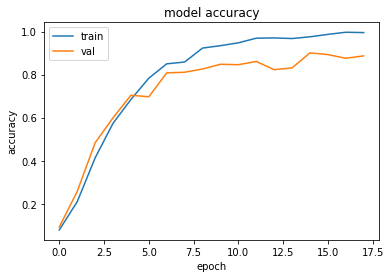

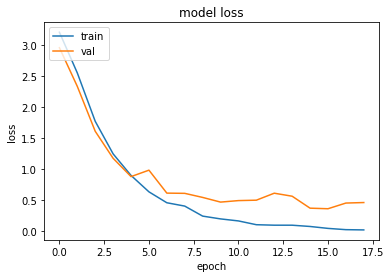

In [148]:
# summarize history for accuracy
plt.plot(history_complex.history['accuracy'])
plt.plot(history_complex.history['val_accuracy'])
plt.title('FIg3. model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_complex.history['loss'])
plt.plot(history_complex.history['val_loss'])
plt.title('Fig4. model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left');

In [149]:
# evaluate the model
_,acc_val=model.evaluate(X_val, y_vl)
_,acc_test=model.evaluate(X_tst, y_ts)
print(f'Val accuracy: {round(acc_val*100, 2)} %, test accuracy: {round(acc_test*100, 2)}%')

1000/1000 [==============================] - 2s 2ms/step
Val accuracy: 90.1 %, test accuracy: 89.2%


## Simpler model

In [150]:
# try simpler model
# create model
model=Sequential()
model.add(Conv2D(128,kernel_size=(3,3),
                 strides=1,padding='same', kernel_initializer='he_uniform',activation='elu',input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(64, kernel_size=(2,2),
                 strides=1, padding='same', kernel_initializer='he_uniform',activation='elu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2, padding='same'))
model.add(Conv2D(32,kernel_size=(2,2),
                strides=1, padding='same', activation='elu',kernel_initializer='he_uniform'))
model.add(MaxPool2D(pool_size=(2,2), strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=512,activation='elu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=25,activation='softmax'))

# early stopping
early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=3, restore_best_weights=True)
# compile model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

history_simpler = model.fit(X_trn,
                      y_tr,
                      epochs = 100,
                      batch_size=50,
                      validation_data=(X_val, y_vl),
                      callbacks=[early_stop])

Train on 2500 samples, validate on 1000 samples
Epoch 1/100
2500/2500 [==============================] - 9s 3ms/step - loss: 2.9351 - accuracy: 0.1676 - val_loss: 1.9491 - val_accuracy: 0.4040
Epoch 2/100
2500/2500 [==============================] - 8s 3ms/step - loss: 1.2717 - accuracy: 0.6148 - val_loss: 1.0003 - val_accuracy: 0.6660
Epoch 3/100
2500/2500 [==============================] - 8s 3ms/step - loss: 0.6284 - accuracy: 0.7988 - val_loss: 0.6988 - val_accuracy: 0.7940
Epoch 4/100
2500/2500 [==============================] - 8s 3ms/step - loss: 0.3627 - accuracy: 0.8836 - val_loss: 0.5660 - val_accuracy: 0.8090
Epoch 5/100
2500/2500 [==============================] - 8s 3ms/step - loss: 0.2276 - accuracy: 0.9368 - val_loss: 0.4248 - val_accuracy: 0.8560
Epoch 6/100
2500/2500 [==============================] - 8s 3ms/step - loss: 0.1381 - accuracy: 0.9632 - val_loss: 0.3922 - val_accuracy: 0.8720
Epoch 7/100
2500/2500 [==============================] - 8s 3ms/step - loss: 0.092

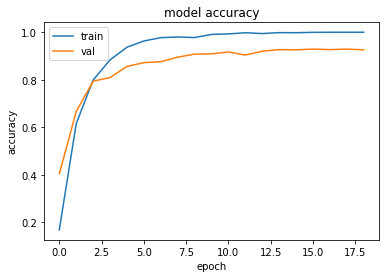

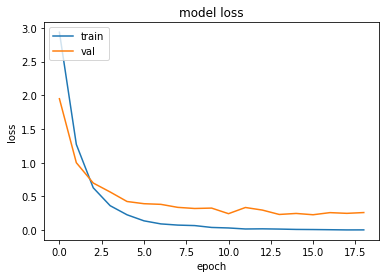

In [152]:
# summarize history for accuracy
plt.plot(history_simpler.history['accuracy'])
plt.plot(history_simpler.history['val_accuracy'])
plt.title('Fig5. model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_simpler.history['loss'])
plt.plot(history_simpler.history['val_loss'])
plt.title('Fig6. model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left');

In [153]:
# evaluate the model
_,acc_val=model.evaluate(X_val, y_vl)
_,acc_test=model.evaluate(X_tst, y_ts)
print(f'Val accuracy: {round(acc_val*100, 2)} %, test accuracy: {round(acc_test*100, 2)}%')

1000/1000 [==============================] - 1s 703us/step
Val accuracy: 92.9 %, test accuracy: 92.4%


## Simpler model with different LR

### LR=0.0001

In [164]:
# create model
model=Sequential()
model.add(Conv2D(128,kernel_size=(3,3),
                 strides=1,padding='same', kernel_initializer='he_uniform',activation='elu',input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(64, kernel_size=(2,2),
                 strides=1, padding='same', kernel_initializer='he_uniform',activation='elu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2, padding='same'))
model.add(Conv2D(32,kernel_size=(2,2),
                strides=1, padding='same', activation='elu',kernel_initializer='he_uniform'))
model.add(MaxPool2D(pool_size=(2,2), strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=512,activation='elu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=25,activation='softmax'))

# early stopping
early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=3, restore_best_weights=True)
# compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

history_simpler_lr1 = model.fit(X_trn,
                      y_tr,
                      epochs = 100,
                      batch_size=50,
                      validation_data=(X_val, y_vl),
                      callbacks=[early_stop])
_,acc_val=model.evaluate(X_val, y_vl)
_,acc_test=model.evaluate(X_tst, y_ts)
print(f'Val accuracy: {round(acc_val*100, 2)} %, test accuracy: {round(acc_test*100, 2)}%')

Train on 2500 samples, validate on 1000 samples
Epoch 1/100
2500/2500 [==============================] - 8s 3ms/step - loss: 3.3213 - accuracy: 0.0540 - val_loss: 3.1014 - val_accuracy: 0.0940
Epoch 2/100
2500/2500 [==============================] - 8s 3ms/step - loss: 2.9981 - accuracy: 0.1336 - val_loss: 2.9108 - val_accuracy: 0.1750
Epoch 3/100
2500/2500 [==============================] - 8s 3ms/step - loss: 2.6886 - accuracy: 0.2692 - val_loss: 2.6095 - val_accuracy: 0.2200
Epoch 4/100
2500/2500 [==============================] - 8s 3ms/step - loss: 2.2971 - accuracy: 0.3772 - val_loss: 2.2517 - val_accuracy: 0.3810
Epoch 5/100
2500/2500 [==============================] - 8s 3ms/step - loss: 1.9143 - accuracy: 0.4944 - val_loss: 1.9148 - val_accuracy: 0.4900
Epoch 6/100
2500/2500 [==============================] - 8s 3ms/step - loss: 1.5594 - accuracy: 0.5916 - val_loss: 1.5977 - val_accuracy: 0.5820
Epoch 7/100
2500/2500 [==============================] - 8s 3ms/step - loss: 1.308

### LR=0.1

In [165]:
# create model
model=Sequential()
model.add(Conv2D(128,kernel_size=(3,3),
                 strides=1,padding='same', kernel_initializer='he_uniform',activation='elu',input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(64, kernel_size=(2,2),
                 strides=1, padding='same', kernel_initializer='he_uniform',activation='elu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2, padding='same'))
model.add(Conv2D(32,kernel_size=(2,2),
                strides=1, padding='same', activation='elu',kernel_initializer='he_uniform'))
model.add(MaxPool2D(pool_size=(2,2), strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=512,activation='elu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=25,activation='softmax'))

# early stopping
early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=3, restore_best_weights=True)
# compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.1),loss='categorical_crossentropy',metrics=['accuracy'])

history_simpler_lr2 = model.fit(X_trn,
                      y_tr,
                      epochs = 100,
                      batch_size=50,
                      validation_data=(X_val, y_vl),
                      callbacks=[early_stop])
_,acc_val=model.evaluate(X_val, y_vl)
_,acc_test=model.evaluate(X_tst, y_ts)
print(f'Val accuracy: {round(acc_val*100, 2)} %, test accuracy: {round(acc_test*100, 2)}%')

Train on 2500 samples, validate on 1000 samples
Epoch 1/100
2500/2500 [==============================] - 8s 3ms/step - loss: 3112.1598 - accuracy: 0.0444 - val_loss: 52.7394 - val_accuracy: 0.0260
Epoch 2/100
2500/2500 [==============================] - 8s 3ms/step - loss: 84.7440 - accuracy: 0.0444 - val_loss: 26.4552 - val_accuracy: 0.0430
Epoch 3/100
2500/2500 [==============================] - 8s 3ms/step - loss: 55.3250 - accuracy: 0.0356 - val_loss: 25.9402 - val_accuracy: 0.0430
Epoch 4/100
2500/2500 [==============================] - 8s 3ms/step - loss: 42.3716 - accuracy: 0.0408 - val_loss: 17.5262 - val_accuracy: 0.0360
Epoch 5/100
1000/1000 [==============================] - 1s 659us/step
Val accuracy: 4.3 %, test accuracy: 4.2%


### Try different dropout rate(0.5)

In [166]:
# create model
model=Sequential()
model.add(Conv2D(128,kernel_size=(3,3),
                 strides=1,padding='same', kernel_initializer='he_uniform',activation='elu',input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(64, kernel_size=(2,2),
                 strides=1, padding='same', kernel_initializer='he_uniform',activation='elu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2, padding='same'))
model.add(Conv2D(32,kernel_size=(2,2),
                strides=1, padding='same', activation='elu',kernel_initializer='he_uniform'))
model.add(MaxPool2D(pool_size=(2,2), strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=512,activation='elu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=25,activation='softmax'))

# early stopping
early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=3, restore_best_weights=True)
# compile model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

history_simpler_dr1 = model.fit(X_trn,
                      y_tr,
                      epochs = 100,
                      batch_size=50,
                      validation_data=(X_val, y_vl),
                      callbacks=[early_stop])
_,acc_val=model.evaluate(X_val, y_vl)
_,acc_test=model.evaluate(X_tst, y_ts)
print(f'Val accuracy: {round(acc_val*100, 2)} %, test accuracy: {round(acc_test*100, 2)}%')

Train on 2500 samples, validate on 1000 samples
Epoch 1/100
2500/2500 [==============================] - 9s 3ms/step - loss: 3.1808 - accuracy: 0.1228 - val_loss: 2.4523 - val_accuracy: 0.2730
Epoch 2/100
2500/2500 [==============================] - 8s 3ms/step - loss: 1.7552 - accuracy: 0.4604 - val_loss: 1.3666 - val_accuracy: 0.5440
Epoch 3/100
2500/2500 [==============================] - 8s 3ms/step - loss: 1.0022 - accuracy: 0.6764 - val_loss: 0.8596 - val_accuracy: 0.7270
Epoch 4/100
2500/2500 [==============================] - 8s 3ms/step - loss: 0.6004 - accuracy: 0.8100 - val_loss: 0.6353 - val_accuracy: 0.7860
Epoch 5/100
2500/2500 [==============================] - 8s 3ms/step - loss: 0.4406 - accuracy: 0.8584 - val_loss: 0.5366 - val_accuracy: 0.8460
Epoch 6/100
2500/2500 [==============================] - 8s 3ms/step - loss: 0.3272 - accuracy: 0.8900 - val_loss: 0.4805 - val_accuracy: 0.8380
Epoch 7/100
2500/2500 [==============================] - 8s 3ms/step - loss: 0.243

In [0]:
# Summarise your results here:
# - include learning curves plus anything else you've used for your decisions
# - it is OK if you have also shown these results in the cell above (in fact that is normal)
#    just show the results again here, but next to each other so they are easy to compare
#    side by side


**Consider all out models:**
- complex
-simpler lr = 0.001
-simpler lr = 0.0001
-simpler lr = 0.1
-simpler lr = 0.001 dropout rate = 0.5

## Accuracies

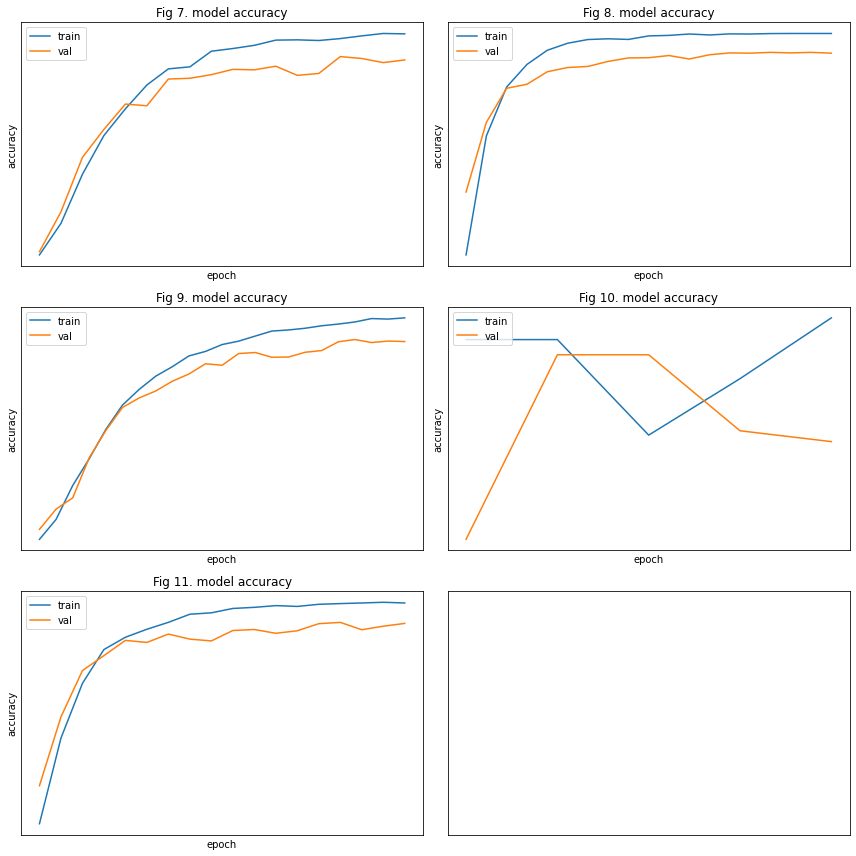

In [183]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})
hists = [history_complex, history_simpler, history_simpler_lr1, history_simpler_lr2, history_simpler_dr1]
for i, (ax, h) in enumerate(zip(axs.flat, hists)):
    ax.plot(h.history['accuracy'])
    ax.plot(h.history['val_accuracy'])
    ax.set_title(f'Fig {i+7}. model accuracy')
    ax.set_ylabel('accuracy')
    ax.set_xlabel('epoch')
    ax.legend(['train', 'val'], loc='upper left')
    
    
    
# tight_layout automatically adjusts subplot params so that the subplot(s) fits in to the figure area
plt.tight_layout()



## Losses

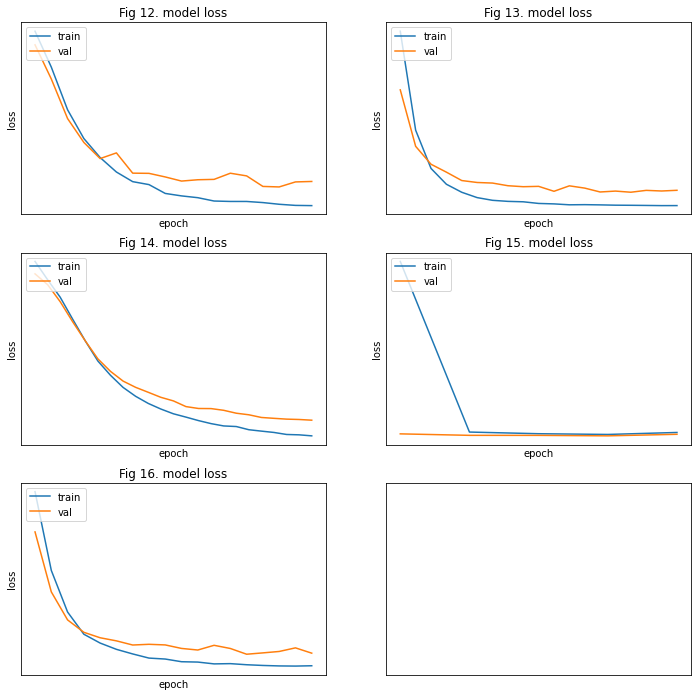

In [186]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})
hists = [history_complex, history_simpler, history_simpler_lr1, history_simpler_lr2, history_simpler_dr1]
for i, (ax, h) in enumerate(zip(axs.flat, hists)):
    ax.plot(h.history['loss'])
    ax.plot(h.history['val_loss'])
    ax.set_title(f'Fig {i+12}. model loss')
    ax.set_ylabel('loss')
    ax.set_xlabel('epoch')
    ax.legend(['train', 'val'], loc='upper left')

## Summary

The best result showed 'simpler' model(fig. 8 and fig. 13). The last model (fig. 11 and fig. 16) performed almost the same. So, we can conclude that dropout rate have slightly impact on our model. We can see that 'complex' model and 'simpler' with higher learning rate perform worse.
92.4% is the best accuracy we have gotten so far. 

### Question 3.4

Once you have performed your systematic optimisation, choose the best network from all of your results.
- Explain why you chose this particular network.
- Were there one or more other networks with very similar performance?  
- If so, did they share particular design features (e.g. size, number of elements, etc)?

'Simpler' with default learning_rate is the best network of all my results. It was 1 network('simpler dr1') with very similar performance, but it showed more unstable. This 2 network are very similar, they differ only by dropout rate parameter. 

### 3.5 Show Results 
Take the best network and show the confusion matrix for its predictions.

In [188]:
model=Sequential()
model.add(Conv2D(128,kernel_size=(3,3),
                 strides=1,padding='same', kernel_initializer='he_uniform',activation='elu',input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(64, kernel_size=(2,2),
                 strides=1, padding='same', kernel_initializer='he_uniform',activation='elu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2, padding='same'))
model.add(Conv2D(32,kernel_size=(2,2),
                strides=1, padding='same', activation='elu',kernel_initializer='he_uniform'))
model.add(MaxPool2D(pool_size=(2,2), strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=512,activation='elu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=25,activation='softmax'))

# early stopping
early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=3, restore_best_weights=True)
# compile model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

history_simpler = model.fit(X_trn,
                      y_tr,
                      epochs = 100,
                      batch_size=50,
                      validation_data=(X_val, y_vl),
                      callbacks=[early_stop])

Train on 2500 samples, validate on 1000 samples
Epoch 1/100
2500/2500 [==============================] - 9s 3ms/step - loss: 2.9919 - accuracy: 0.1556 - val_loss: 2.0858 - val_accuracy: 0.4250
Epoch 2/100
2500/2500 [==============================] - 8s 3ms/step - loss: 1.3574 - accuracy: 0.5776 - val_loss: 1.0890 - val_accuracy: 0.6490
Epoch 3/100
2500/2500 [==============================] - 8s 3ms/step - loss: 0.6287 - accuracy: 0.8028 - val_loss: 0.6639 - val_accuracy: 0.7450
Epoch 4/100
2500/2500 [==============================] - 8s 3ms/step - loss: 0.3708 - accuracy: 0.8832 - val_loss: 0.5468 - val_accuracy: 0.8160
Epoch 5/100
2500/2500 [==============================] - 8s 3ms/step - loss: 0.2400 - accuracy: 0.9356 - val_loss: 0.4340 - val_accuracy: 0.8510
Epoch 6/100
2500/2500 [==============================] - 8s 3ms/step - loss: 0.1971 - accuracy: 0.9436 - val_loss: 0.4187 - val_accuracy: 0.8630
Epoch 7/100
2500/2500 [==============================] - 8s 3ms/step - loss: 0.113

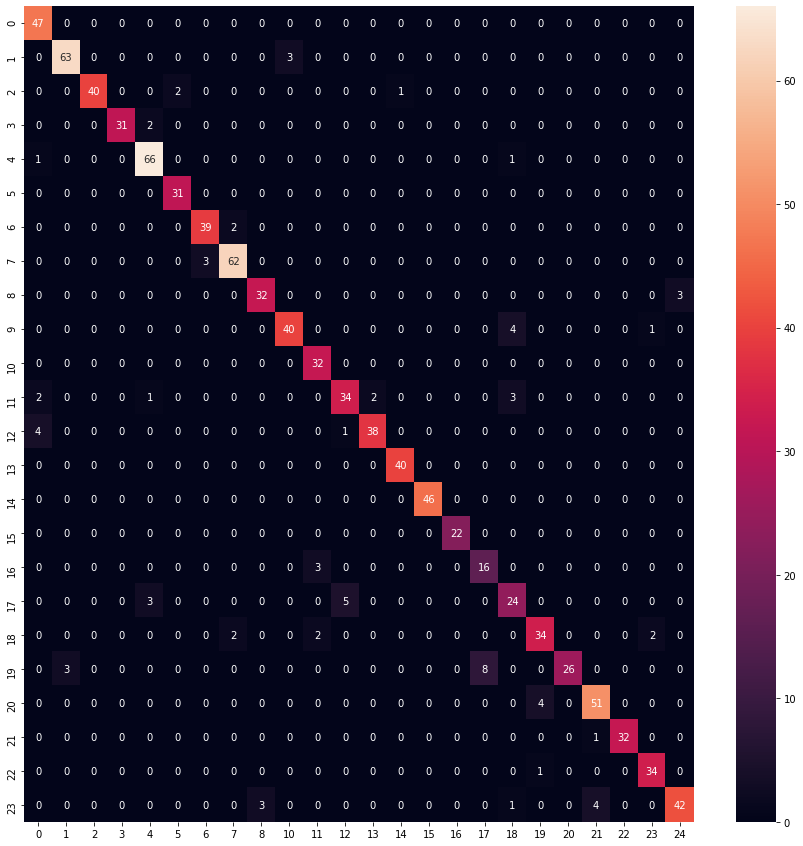

In [260]:
predictions = model.predict_classes(X_tst)
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
cm = confusion_matrix(test_label[1000:2000],predictions)
cm = pd.DataFrame(cm,  index = [i for i in range(25) ] , columns = [i for i in range(25)])
cm = pd.concat([cm.iloc[:-1, :9], cm.iloc[:-1, 10:]], axis=1)
plt.figure(figsize = (15,15))
sns.heatmap(cm, annot = True, fmt='')

### Question 3.6
 - What class is misclassified the most, and what class is it most typically misclassified as?
 - Give the class numbers and show example images of these.

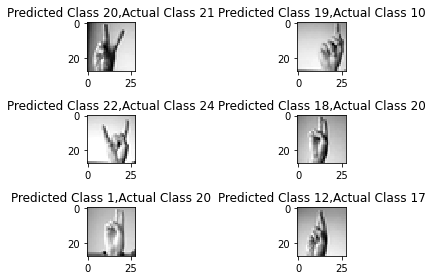

In [262]:
correct = np.nonzero(model.predict_classes(X_tst) == y_tst)[0]
incorrect = np.nonzero(model.predict_classes(X_tst) != y_tst)[0]

i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.imshow(X_tst[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_tst[c]))
    plt.tight_layout()
    i += 1

The most misclassified class is 17. It is classified as 19 8 times

### Question 3.7
 - Summarise (in about 2-3 sentences) what you found out about the tuning and model comparisons that you have done in this section.
 - What aspects (if any) do you think might need to be modified for other problems (e.g. those with much larger datasets)? 

I had found out that learninng curves are very helpful if we want to compare different models. I had seen how different parameters impact on the model. I had tried different architectures of CNN and evaluated their performance.

***

## 4. Free Choice Element (10%)

In this section you can choose to investigate **just one** of the following options for improving the classification performance. Make sure that you explain your process and show appropriate results. Again, the final results are not that important - it is the process that counts.

Options are:
 - Implement new layers such as Dropout and BatchNormalization (see chapter 11 of Géron)
 - Try alternative and deeper CNN layouts, varying the number of Conv2D and MaxPooling layers and their ordering
 - Investigate the effects of larger networks, as well as changing at least one of the following: optimiser, activation function, batch size and/or training set size

 
Report your findings and show the final results.

In [276]:
# add Dropout 
# change architecture
#sgd optimizer, relu activation function, change batch size
model=Sequential()
model.add(Conv2D(128,kernel_size=(5,5),
                 strides=1,padding='same', kernel_initializer='he_uniform',activation='relu',input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(64, kernel_size=(3,3),
                 strides=1, padding='same', kernel_initializer='he_uniform',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2, padding='same'))
model.add(Conv2D(32,kernel_size=(3,3),
                strides=1, padding='same', activation='relu',kernel_initializer='he_uniform'))
model.add(MaxPool2D(pool_size=(2,2), strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=512,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=25,activation='softmax'))

# early stopping
early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=3, restore_best_weights=True)
# compile model
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

history_free = model.fit(X_trn,
                      y_tr,
                      epochs = 100,
                      batch_size=128,
                      validation_data=(X_val, y_vl),
                      callbacks=[early_stop])


Train on 2500 samples, validate on 1000 samples
Epoch 1/100
2500/2500 [==============================] - 11s 4ms/step - loss: 3.1853 - accuracy: 0.0664 - val_loss: 3.0711 - val_accuracy: 0.0740
Epoch 2/100
2500/2500 [==============================] - 11s 4ms/step - loss: 2.6546 - accuracy: 0.2192 - val_loss: 2.1397 - val_accuracy: 0.3810
Epoch 3/100
2500/2500 [==============================] - 11s 4ms/step - loss: 1.7021 - accuracy: 0.4832 - val_loss: 1.4427 - val_accuracy: 0.5280
Epoch 4/100
2500/2500 [==============================] - 11s 4ms/step - loss: 1.0531 - accuracy: 0.6616 - val_loss: 0.9905 - val_accuracy: 0.7000
Epoch 5/100
2500/2500 [==============================] - 11s 4ms/step - loss: 0.7059 - accuracy: 0.7736 - val_loss: 0.7193 - val_accuracy: 0.7520
Epoch 6/100
2500/2500 [==============================] - 11s 4ms/step - loss: 0.4778 - accuracy: 0.8484 - val_loss: 0.5501 - val_accuracy: 0.8040
Epoch 7/100
2500/2500 [==============================] - 11s 4ms/step - loss

In [277]:
# evaluate the model
_,acc_val=model.evaluate(X_val, y_vl)
_,acc_test=model.evaluate(X_tst, y_ts)
print(f'Val accuracy: {round(acc_val*100, 2)} %, test accuracy: {round(acc_test*100, 2)}%')

1000/1000 [==============================] - 1s 1ms/step
Val accuracy: 92.6 %, test accuracy: 91.3%


First of all I chose slightly different architecture: kernel size (5,5) in the first convolutional layer, different number of filters. I used relu as activation function and sgd as optimizer. Batch size was increased to 128. We can see that this model performs worse than our previous best model. It shows accuracy 91.3% on validation set.

***